In [5]:
cd /home/watts/lal/Kaggle/lung_cancer

/home/watts/lal/medicine-ai/lung_cancer


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
import argparse
from time import strftime
from tqdm import tqdm
import sys

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi
#from numpy.lib.format import open_memmap
import dicom
import scipy.misc
from utils.my_preprocessing import get_segmented_lungs, get_region_of_interest, remove_two_largest_connected
from utils.my_luna16_segment_lung_ROI import do_lungmask, do_final_processing, do_thresholding

In [7]:
def get_current_date():
    return strftime('%Y%m%d')

In [8]:
# Load the scans in given folder path
def read_ct_scan_gzuidhof(folder_path):
    #print folder_path
    slices = [dicom.read_file(folder_path + '/' + s) for s in os.listdir(folder_path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [15]:
def read_ct_scan(folder_name):
    # Read the slices from the dicom file
    slices = [dicom.read_file(folder_name + '/' + filename) for filename in os.listdir(folder_name)]

    # Sort the dicom slices in their respective order
    slices.sort(key=lambda x: int(x.InstanceNumber))

    # Get the pixel values for all the slices
    slices = np.stack([s.pixel_array for s in slices])
    slices[slices == -2000] = 0
    return slices

def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

In [16]:
args_size = 512
scan_folder = '0015ceb851d7251b8f399e39779d1e7d'
X_images_fname = 'cache/X_images_%s_%s_%s.npy' % (scan_folder, args_size, get_current_date())
X_lungmask_fname = 'cache/X_lungmask_%s_%s_%s.npy' % (scan_folder, args_size, get_current_date())
print X_images_fname

cache/X_images_0015ceb851d7251b8f399e39779d1e7d_512_20170215.npy


(512, 512)
int16


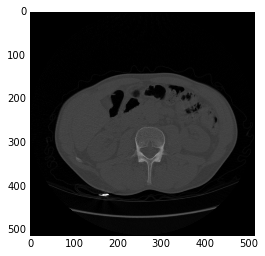

In [30]:
import matplotlib.pyplot as plt
df = pd.read_csv('data/stage1_labels.csv')

df['scan_folder'] = df['id']
i = 0
row = df.iloc[i]
fname = os.path.join('data/stage1/', row['scan_folder'])
#try:
j = 2
scan_folder = row['scan_folder']
#print scan_folder
#patient_slices = read_ct_scan_gzuidhof(fname)
#print len(patient_slices)

patient_slices = read_ct_scan(fname)
#img = patient_slices[j].pixel_array
img = patient_slices[j]
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')



In [31]:
X_images_shape = (len(patient_slices), args_size, args_size)
#print X_images_shape
X_images_fname = 'cache/X_images_%s_%s_%s.npy' % (scan_folder, args_size, get_current_date())
#print X_images_shape, X_images_fname
X_images_fp = np.memmap(X_images_fname, dtype=np.int64, mode='w+', shape=X_images_shape)

X_lungmask_shape = (len(patient_slices), args_size, args_size)
#print X_lungmask_shape
X_lungmask_fname = 'cache/X_lungmask_%s_%s_%s.npy' % (scan_folder, args_size, get_current_date())
print X_lungmask_shape, X_lungmask_fname
X_lungmask_fp = np.memmap(X_lungmask_fname, dtype=np.int64, mode='w+', shape=X_lungmask_shape)
#for slice in patient_slices:

#img = patient_slices[j].pixel_array
img = patient_slices[j]
X_images_fp[j] = img
X_images_fp.flush()

#lungmask = do_lungmask(img)
lungmask = get_segmented_lungs(img)
X_lungmask_fp[j] = lungmask
X_lungmask_fp.flush()
#j = j+1
#print j
#assert(j == len(patient_slices))
#label = row['cancer']
#y_fp[i] = label
#y_fp.flush()

(195, 512, 512) cache/X_lungmask_0015ceb851d7251b8f399e39779d1e7d_512_20170215.npy


(512, 512)
int64


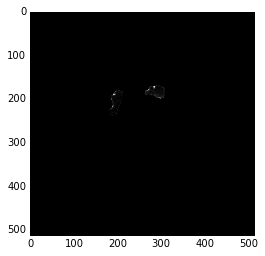

In [32]:
img = X_lungmask_fp[j]
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')

(512, 512)
int64


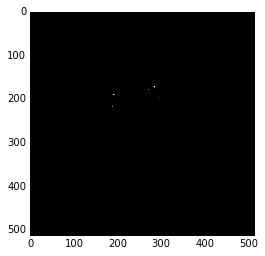

In [33]:
img = X_lungmask_fp[j]
img = get_region_of_interest(img)
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')

In [34]:
segmented_ct_scan = segment_lung_from_ct_scan(patient_slices)
#plot_ct_scan(segmented_ct_scan)

In [35]:
print segmented_ct_scan.shape

(195, 512, 512)


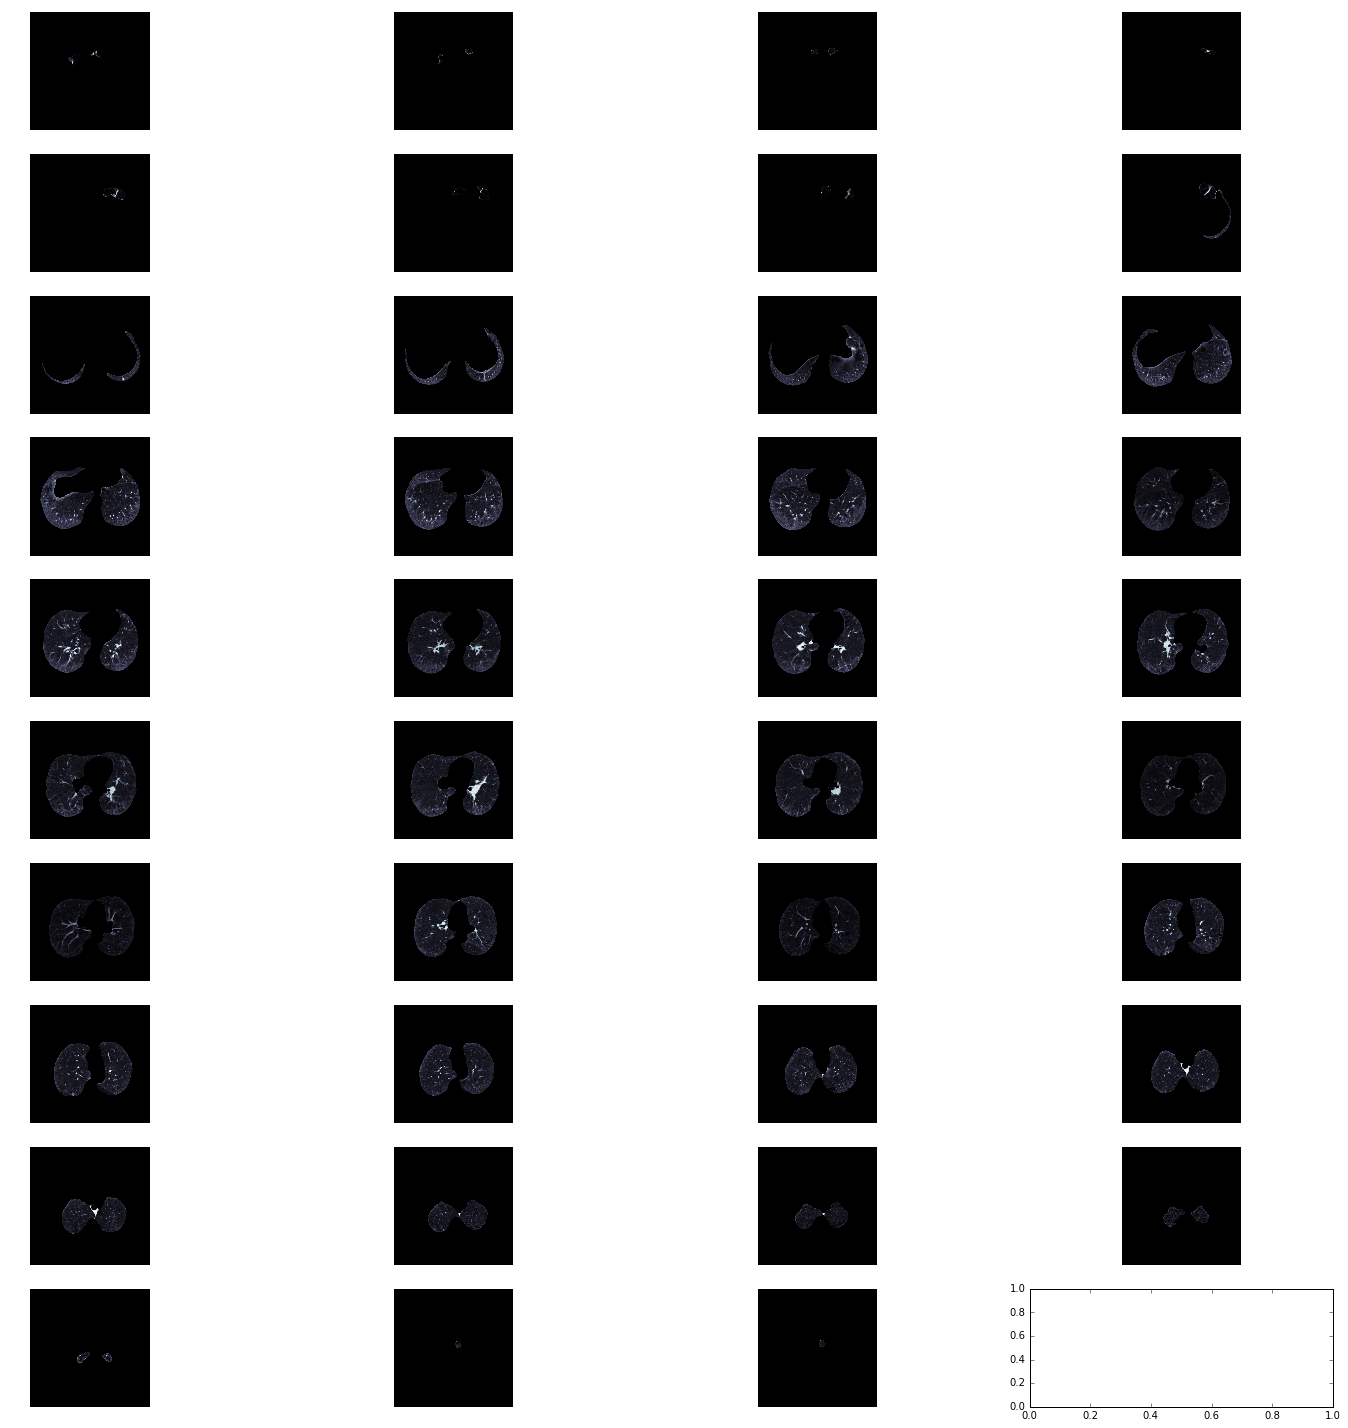

In [36]:
plot_ct_scan(segmented_ct_scan)

In [37]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
#plot_ct_scan(segmented_ct_scan)

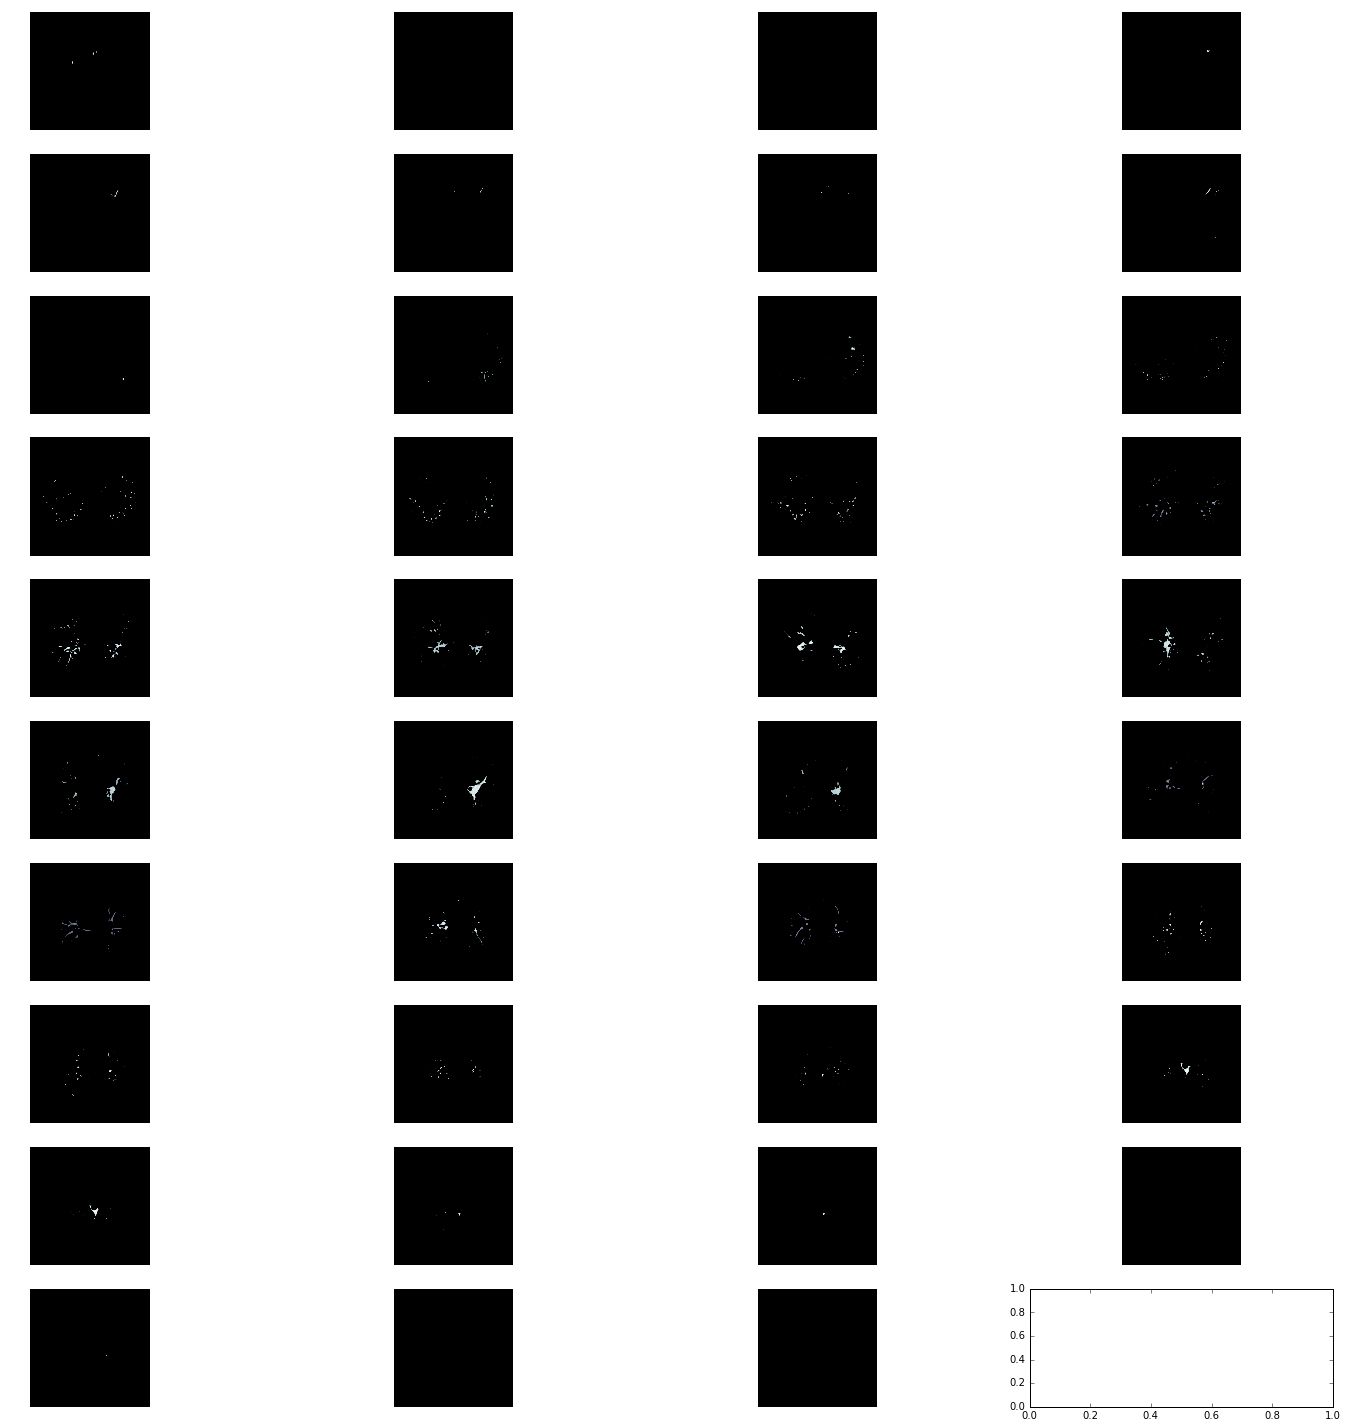

In [38]:
selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000

for c in r.coords:
    max_z = max(c[0], max_z)
    max_y = max(c[1], max_y)
    max_x = max(c[2], max_x)

    min_z = min(c[0], min_z)
    min_y = min(c[1], min_y)
    min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

plot_ct_scan(segmented_ct_scan)

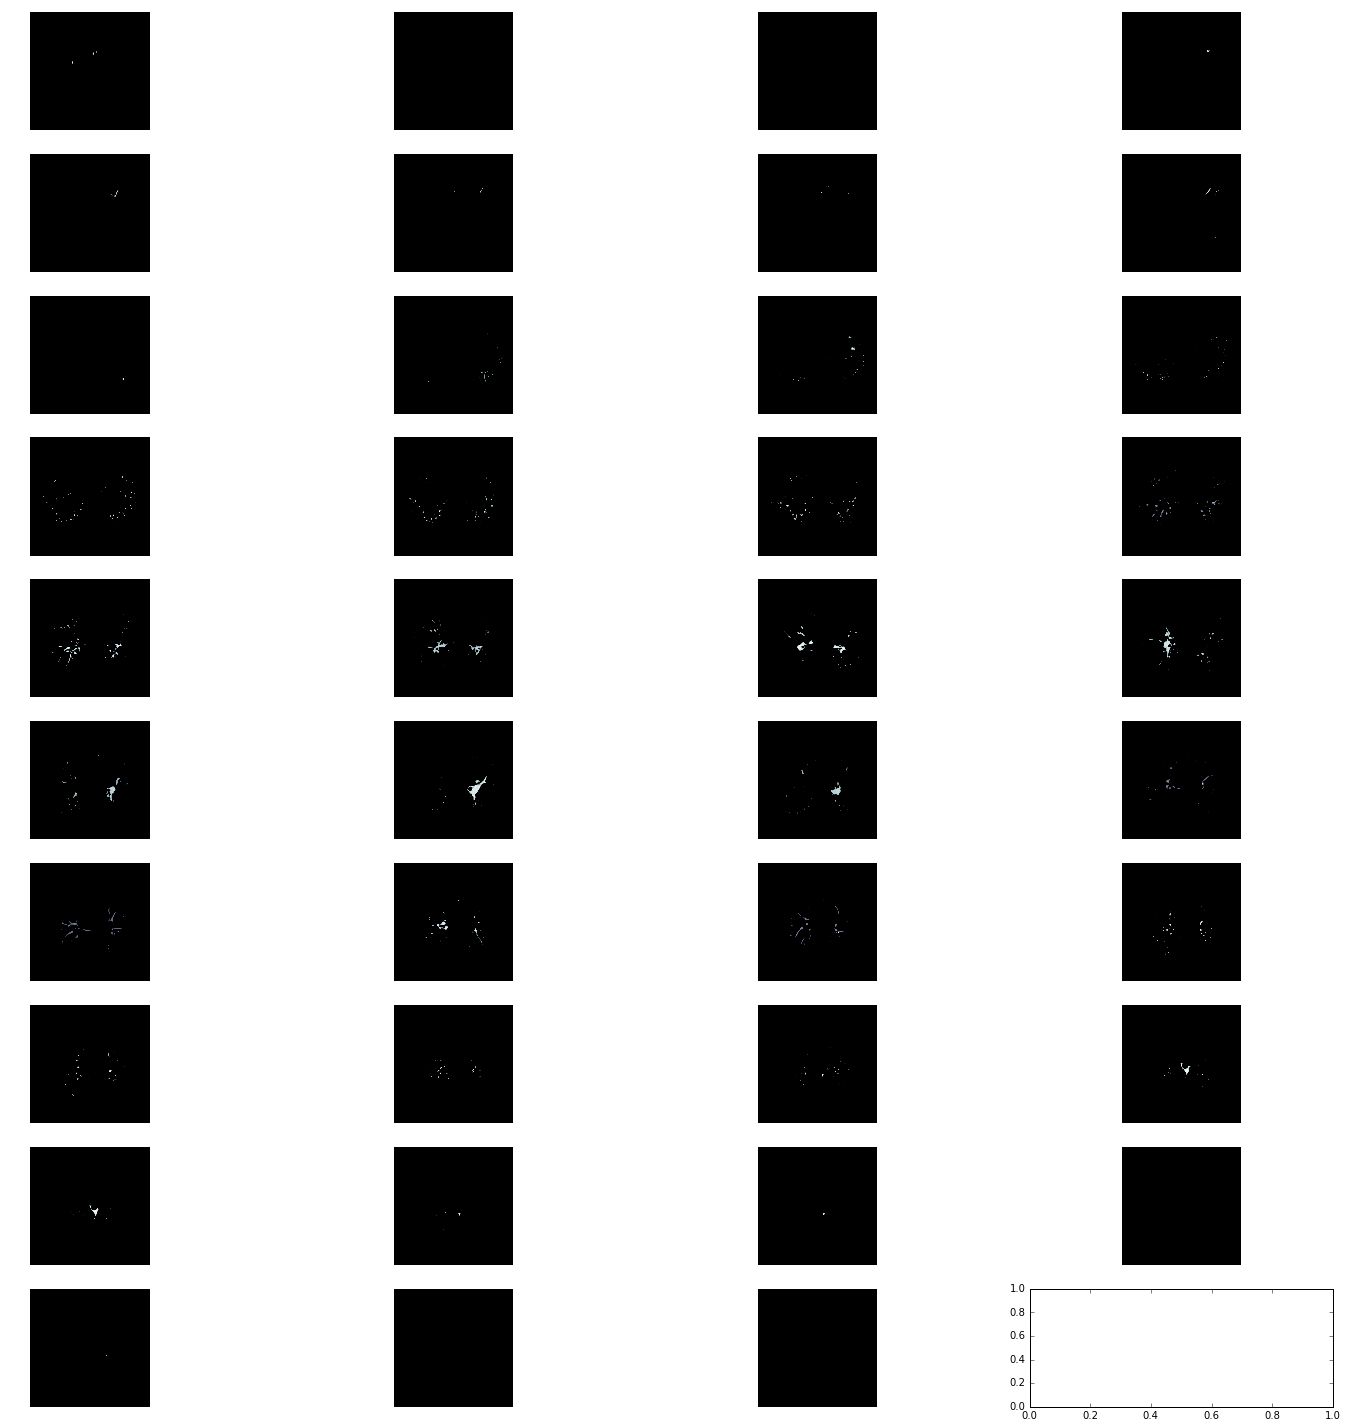

In [26]:
remove_two_largest_connected(patient_slices)
plot_ct_scan(segmented_ct_scan)

In [33]:
#img = X_lungmask_fp[j]
img = remove_two_largest_connected(patient_slices)
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')

AttributeError: 'list' object has no attribute 'shape'

In [19]:
def get_segmented_lungs1(im, plot=False):
    # This funtion segments the lungs from the given 2D slice.
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))

    #Step 1: Convert into a binary image.
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone)

    #Step 2: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone)

    #Step 3: Label the image.
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone)

    #Step 4: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone)

    #Step 5: Erosion operation with a disk of radius 2. This operation is
    #seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone)

    #Step 6: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone)

    #Step 7: Fill in the small holes inside the binary mask of lungs.
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone)

    #Step 8: Superimpose the binary mask on the input image.
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone)

    return im


(512, 512)
int64


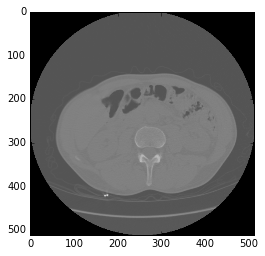

In [20]:
img = X_images_fp[j]
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')

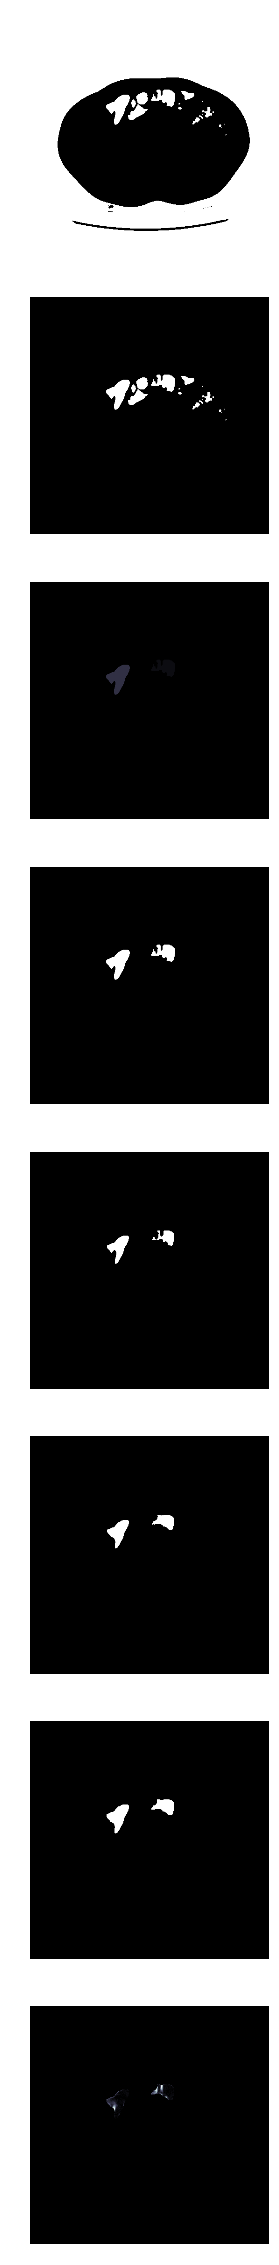

In [21]:
lungmask = get_segmented_lungs1(img, True)

(array([  5.57720000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

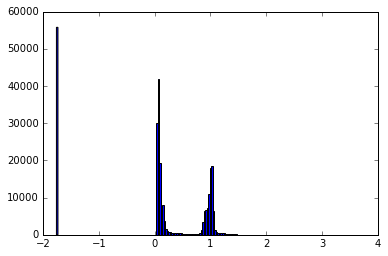

In [9]:
mean = np.mean(img)
std = np.std(img)
img1 = img-mean
img1 = img1/std
plt.hist(img1.flatten(),bins=200)

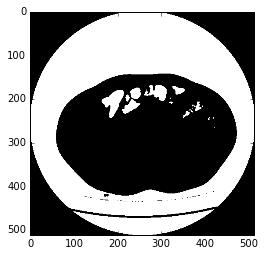

In [10]:
thresh_img = do_thresholding(img)
plt.imshow(thresh_img, cmap='gray')

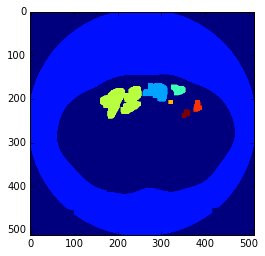

In [11]:
eroded = morphology.erosion(thresh_img,np.ones([4,4]))
dilation = morphology.dilation(eroded,np.ones([10,10]))
labels = measure.label(dilation)
label_vals = np.unique(labels)
plt.imshow(labels)

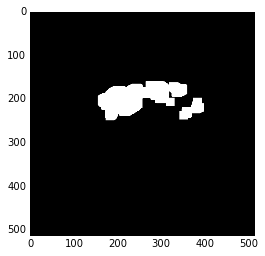

In [12]:
labels = measure.label(dilation)
label_vals = np.unique(labels)
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
        good_labels.append(prop.label)
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
#
#  The mask here is the mask for the lungs--not the nodes
#  After just the lungs are left, we do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
plt.imshow(mask,cmap='gray')

(512, 512)
int64


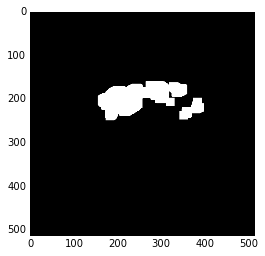

In [13]:
img = X_lungmask_fp[j]
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')

(512, 512)
int64


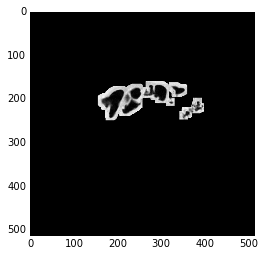

In [14]:
X_images_fp[j] = X_lungmask_fp[j] * X_images_fp[j]
img = X_images_fp[j]
print img.shape
print img.dtype
%matplotlib inline

plt.imshow(img, cmap='gray')

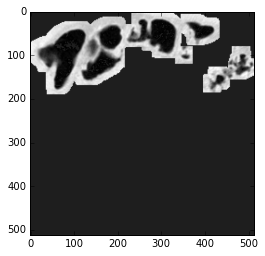

In [15]:
mask = X_lungmask_fp[j]
img= mask*img          # apply lung mask
#
# renormalizing the masked image (in the mask region)
#
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pulling the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std
#make image bounding box  (min row, min col, max row, max col)
labels = measure.label(mask)
regions = measure.regionprops(labels)
#
# Finding the global min and max row over all regions
#
min_row = 512
max_row = 0
min_col = 512
max_col = 0
for prop in regions:
    B = prop.bbox
    if min_row > B[0]:
        min_row = B[0]
    if min_col > B[1]:
        min_col = B[1]
    if max_row < B[2]:
        max_row = B[2]
    if max_col < B[3]:
        max_col = B[3]
width = max_col-min_col
height = max_row - min_row
if width > height:
    max_row=min_row+width
else:
    max_col = min_col+height
# 
# cropping the image down to the bounding box for all regions
# (there's probably an skimage command that can do this in one line)
# 
img = img[min_row:max_row,min_col:max_col]
mask =  mask[min_row:max_row,min_col:max_col]
new_img = ''
if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
    new_img = img
else:
    # moving range to -1 to 1 to accomodate the resize function
    mean = np.mean(img)
    img = img - mean
    min = np.min(img)
    max = np.max(img)
    img = img/(max-min)
    new_img = resize(img,[512,512])
plt.imshow(new_img, cmap='gray')

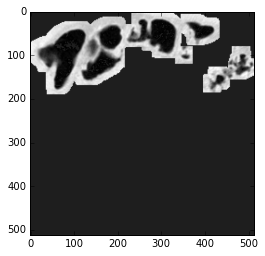

In [16]:
new_img = do_final_processing(X_images_fp[j], X_lungmask_fp[j])
if new_img is not None:
    plt.imshow(new_img, cmap='gray')

In [ ]:


X_train_images_shape = (len(X_images_fp), args.size, args.size)
#print X_train_images_shape
X_train_images_fname = 'cache/X_train_images_%s_%s_%s.npy' % (scan_folder, args.size, get_current_date())
#print X_train_images_fname
X_train_images_fp = np.memmap(X_train_images_fname, dtype=np.int64, mode='w+', shape=X_train_images_shape)


In [ ]:
#print '0..'
for k in range(len(X_images_fp)):
    img = X_images_fp[k]
    mask = X_lungmask_fp[k]
    try:
        new_img = do_final_processing(img, mask)
        if new_img is not None:
            X_train_images_fp[k] = new_img
            X_train_images_fp.flush()
    except:
        print 'failed in %s' %k
print 'Deleting %s %s ..' % X_images_fname, X_lungmask_fname
# now delete imgs and masks
os.remove(X_images_fname) 
os.remove(X_lungmask_fname) 


In [69]:
X_train_images_fname = 'X_train_images_0015ceb851d7251b8f399e39779d1e7d_512_20170215.npy'
imgs = np.memmap(X_train_images_fname, dtype=np.int64, mode='r', shape=(195,512,512))

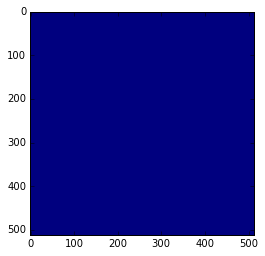

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(imgs[0])
#lt.show()